In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [2]:
print(df.shape)
print('遺漏值數量 = ', df.isnull().sum().sum())

(45211, 17)
遺漏值數量 =  0


In [3]:
# 進行五個特徵(age, balance, duration, campaign, previous)的集群分析
from sklearn.preprocessing import StandardScaler

features = ['age', 'balance', 'duration','campaign', 'previous']
df_data = df[features]

scaler = StandardScaler()
scaler.fit(df_data)
df_std = scaler.transform(df_data)
df_std[:2, :]

array([[ 1.60696496,  0.25641925,  0.0110161 , -0.56935064, -0.25194037],
       [ 0.28852927, -0.43789469, -0.41612696, -0.56935064, -0.25194037]])

In [4]:
# 使用轉折圖判斷分群數目
from sklearn.cluster import KMeans

lst_dist = []
for i in range(1, 20):
    clt = KMeans(n_clusters=i, n_jobs=-1)
    clt.fit(df_std)
    lst_dist.append(clt.inertia_)

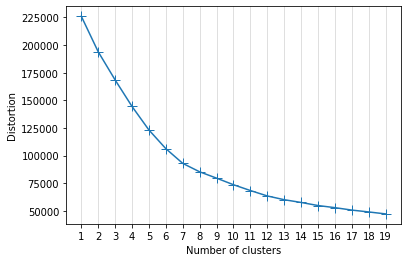

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(1, 20), lst_dist, marker='+', markersize=10)
plt.xticks(range(1, 20))
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.grid(axis='x', alpha=0.5);

n_clusters = 5 ，所有樣本的輪廓係數平均 = 0.3029599782273954
n_clusters = 6 ，所有樣本的輪廓係數平均 = 0.3180493857960702
n_clusters = 7 ，所有樣本的輪廓係數平均 = 0.3196603013608003


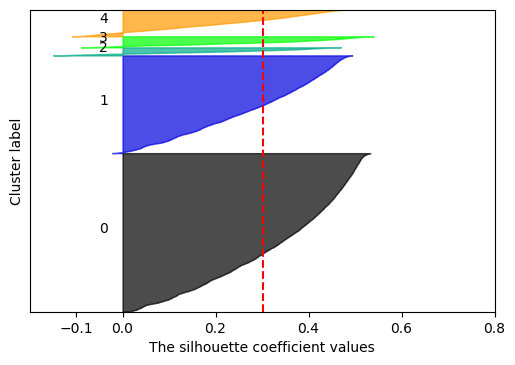

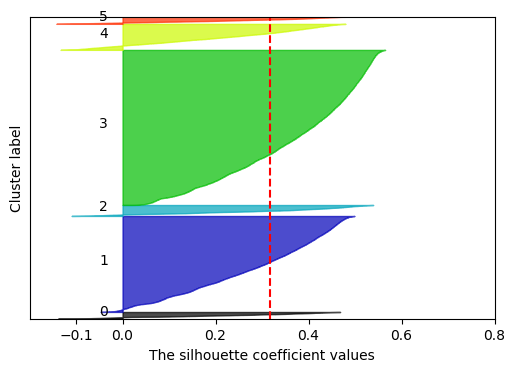

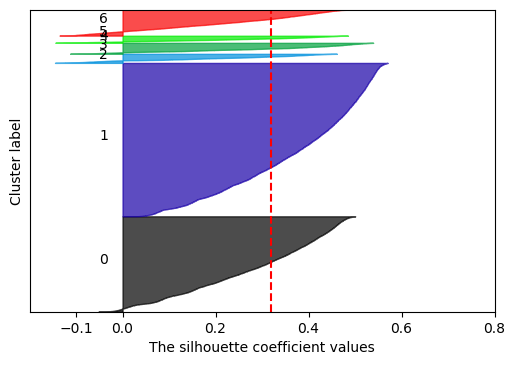

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm

for n_clusters in [5, 6, 7]:
    fig, ax = plt.subplots(1, 1, dpi=100)
    # 輪廓係數範圍是[-1, 1]，但這裡只顯示[-0.2, 0.8]之間
    ax.set_xlim([-.2, .8])
    ax.set_ylim([0, len(df_std)+(n_clusters+1)*10])
    # 建立 k-means 模型並擬合數據
    km = KMeans(n_clusters=n_clusters, n_jobs=-1)
    y_pred = km.fit_predict(df_std)
    # 取出分群結果的標籤
    labels = np.unique(y_pred)
    # 計算所有樣本的輪廓係數平均值
    silhouette_avg = silhouette_score(df_std, y_pred)
    print("n_clusters =", n_clusters,
          "，所有樣本的輪廓係數平均 =", silhouette_avg)
    # 計算每個樣本的輪廓係數
    silhouette = silhouette_samples(df_std, y_pred, metric='euclidean')
    y_lower = 10
    
    for i, c in enumerate(labels):
        c_silhouette = silhouette[y_pred == c]
        c_silhouette.sort()
        size_cluster_i = c_silhouette.shape[0]
        y_upper = y_lower + size_cluster_i
        # 產生顏色編號，並填入區間內
        color = cm.nipy_spectral(float(i)/n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),0, 
                         c_silhouette, facecolor=color, 
                         edgecolor=color, alpha=0.7)
        # 標示集群標籤
        ax.text(-0.05, y_lower+0.5*size_cluster_i, str(i))
        y_lower = y_upper + 10
        
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8])

In [7]:
clt = KMeans(n_clusters=6, n_jobs=-1)
clt.fit(df_std)

labels = pd.Series(clt.labels_, name='clt_number')
print(labels.value_counts(sort=False))

0    23176
1    14310
2     3897
3     1638
4      999
5     1191
Name: clt_number, dtype: int64


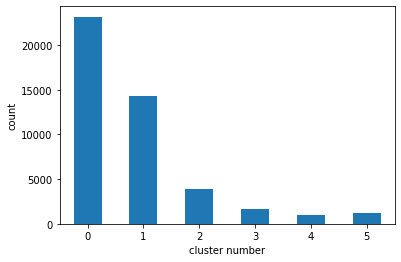

In [8]:
ax = labels.value_counts(sort=False).plot(kind='bar')
ax.set_xticklabels(range(6), rotation=0)
ax.set_xlabel('cluster number')
ax.set_ylabel('count');

In [9]:
df_new = pd.concat([df, labels], axis=1)
df_new.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,clt_number
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0


In [10]:
# 設定分割間隔
bins = list(range(15, 65, 5)) + [100]
bin_age = pd.cut(df_new['age'], bins, right=False)

# 結合群體編號與年齡層
df_bin = pd.concat([df_new['clt_number'], bin_age], axis=1)
df_group_age = df_bin.groupby(['clt_number', 'age']).size().unstack()

df_group_age.loc[-1, :] = df_group_age.sum(axis=0)
df_group_age.index = [0, 1, 2, 3, 4, 5, 'total']
df_group_age

age,"[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 100)"
0,45.0,662.0,3749.0,8107.0,6761.0,3852.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1105.0,4549.0,3786.0,3350.0,1520.0
2,0.0,59.0,409.0,811.0,838.0,643.0,464.0,328.0,253.0,92.0
3,2.0,14.0,140.0,380.0,339.0,262.0,213.0,149.0,110.0,29.0
4,0.0,18.0,98.0,222.0,210.0,130.0,97.0,95.0,67.0,62.0
5,0.0,9.0,68.0,220.0,201.0,193.0,147.0,130.0,142.0,81.0
total,47.0,762.0,4464.0,9740.0,8349.0,6185.0,5470.0,4488.0,3922.0,1784.0


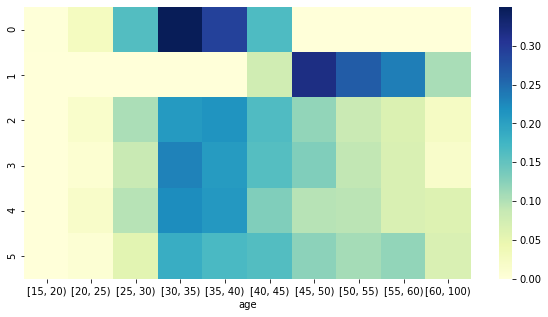

In [11]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df_group_age.iloc[:-1, :].apply(lambda x: x/x.sum(), axis=1), 
            cmap='YlGnBu', ax=ax)